Scaling Methods:
- Resized 84,484 images (5 GB as jpeg) from 224 x 224 x 3 (12 GB as numpy array) to a smaller 112 x 112 x 3 (3 GB as numpy array) to use less memory and perform faster.  
- Used 1 GPU. 

Tradeoffs:
- Resizing to smaller images potentially lose slight accuracy and precision to perform faster since we are working with less data. It may also at the same time potentially reduce noise for a model.
- 1 GPU is free. More GPU = more money, less GPU = more time to train.
- Tradeoffs between VGG16 and Resnet: VGG16 trained faster, but had a lower score. Resnet trained slower, but had a higher score.

Results for VGG16:
- Duration without scaling for VGG16: 1/8th of the dataset in 11861.866 seconds (3.295 hours).
- Duration with scaling for VGG16: full dataset in 1628.153 seconds (0.452 hours).
- Metrics without scaling for VGG16 Best Model: Training Accuracy of 0.854 and Validation Accuracy of 0.811.  
- Metrics with scaling for VGG16 Best Model: Training Accuracy of 0.816 and Validation Accuracy of 0.782.
- VGG16 Model was faster, but performed slightly worse with the full dataset, smaller resized images, and GPU.  

Results for Resnet:
- Duration without scaling for Resnet: 1/8th of the dataset in 42246.937 seconds (11.735 hours).
- Duration with scaling for Resnet: full dataset in 10225.247 seconds (2.84 hours).
- Metrics without scaling for Resnet Best Model: Training Accuracy of 0.948 and Validation Accuracy of 0.739.  
- Metrics with scaling for Resnet Best Model: Training Accuracy of 0.939 and Validation Accuracy of 0.904.
- Resnet Model was actually both faster and performed better with the full dataset, smaller resized images, and GPU.

In [1]:
# ===== 0. Check for GPU
# GPU: Tesla K80, Driver Version: 430.40
# CUDA Version: 10.1
! nvidia-smi

import tensorflow as tf
import tensorflow.keras
from tensorflow.python.client import device_lib

print("Tensorflow Version:", tf.__version__)
print("Is Build with CUDA:", tf.test.is_built_with_cuda())
print("Is GPU available:", tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None))
print(device_lib.list_local_devices())

Sat Aug  3 14:50:10 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 430.40       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P0    65W / 149W |     17MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
# ===== 1. Read Images from HDF5
import numpy as np
import time
import h5py
# import keras
import cv2
import psutil
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, Sequential, model_from_json, load_model
from tensorflow.keras.applications import vgg16, vgg19, resnet50
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization, Activation, Input, AveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight, shuffle
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler
from math import ceil

DATASET_FILE = 'dataset.h5'
DATASET_FILE_MINI = 'dataset_mini.h5'
DATASET_IMAGES = 'images'
DATASET_LABELS = 'labels'
IMAGE_DIMENSION = 112
IMAGE_INPUT_SHAPE = (IMAGE_DIMENSION, IMAGE_DIMENSION, 3)
LABEL_CLASS = { 'NORMAL': 0, 'CNV': 1, 'DME': 2, 'DRUSEN': 3 }
NUM_CLASSES = len(LABEL_CLASS)
NUM_BATCH_SIZE_BASE = 128
NUM_BATCH_SIZE_VGG16 = 128
NUM_BATCH_SIZE_RESNET = 32
NUM_EPOCHS = 100
NUM_DEPTH = 29
MODEL_NAME_BASE = 'model_base.h5'
MODEL_NAME_VGG16 = 'model_vgg16.h5'
MODEL_NAME_RESNET = 'model_resnet.h5'

# Utils
start_time = time.time()
def watch_restart():
    global start_time
    start_time = time.time()
def watch_print(title):
    global start_time
    print(title, (time.time() - start_time), 'seconds')
def memory_print():
    memory = dict(psutil.virtual_memory()._asdict())
    print("Memory Capacity", memory['total'] >> 30, "GB")
    print("Memory Left", memory['free'] >> 30, "GB")
    print("Memory Used", memory['used'] >> 30, "GB")
    print("Memory Used:", memory['percent'], "percent")
def get_label(src):
    global LABEL_CLASS
    for key, value in LABEL_CLASS.items():
        if value == src:
            return key
# Learning Rate
def lr_schedule(epochs):
    lr = 1e-3
    if epochs > 180:
        lr *= 0.5e-3
    elif epochs > 160:
        lr *= 1e-3
    elif epochs > 120:
        lr *= 1e-2
    elif epochs > 80:
        lr *= 1e-1
    return lr

# Callbacks for model saving and stopping.
# Training should be stopped when val_acc (validation accuracy) clearly stops increasing to prevent overfitting.
checkpoint_base = ModelCheckpoint(filepath=MODEL_NAME_BASE, monitor='val_acc', verbose=1, save_best_only=True)
checkpoint_vgg16 = ModelCheckpoint(filepath=MODEL_NAME_VGG16, monitor='val_acc', verbose=1, save_best_only=True)
checkpoint_resnet = ModelCheckpoint(filepath=MODEL_NAME_RESNET, monitor='val_acc', verbose=1, save_best_only=True)
lr_scheduler = LearningRateScheduler(lr_schedule)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
early_stopping_base = EarlyStopping(monitor='val_acc', patience=2, verbose=1)
early_stopping = EarlyStopping(monitor='val_acc', patience=10, verbose=1)

# Read
hf = h5py.File(DATASET_FILE, 'r')
X = np.array(hf[DATASET_IMAGES]).astype('float32')
y = np.array(hf[DATASET_LABELS]).astype('uint8')
hf.close()

memory_print()
watch_print('Read Images from HDF5')

Memory Capacity 51 GB
Memory Left 33 GB
Memory Used 12 GB
Memory Used: 26.0 percent
Read Images from HDF5 11.761530637741089 seconds


In [3]:
watch_restart()

# ===== 2. Prepare Data

# Normalize input data.
# Neural Networks work best when input data are between 0 and 1 (Instead of 0 to 255).
X = X / 255

print("Images Shape", X.shape)
print("Labels Shape", y.shape)

# Split Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X = y = None

# Adjust with imbalanced class frequency
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)
Y_train = y_train
Y_test = y_test
ros = RandomUnderSampler(ratio='auto')
X_trainRos, Y_trainRos = ros.fit_sample(X_trainFlat, Y_train)
X_testRos, Y_testRos = ros.fit_sample(X_testFlat, Y_test)

# Adjust labels
# Neural Networks will have as many number of outputs as the number of classes.
Y_trainRosHot = to_categorical(Y_trainRos, num_classes = NUM_CLASSES)
Y_testRosHot = to_categorical(Y_testRos, num_classes = NUM_CLASSES)

# Make Data 2D again
for i in range(len(X_trainRos)):
    height, width, channels = IMAGE_DIMENSION,IMAGE_DIMENSION,3
    X_trainRosReshaped = X_trainRos.reshape(len(X_trainRos),height,width,channels)
for i in range(len(X_testRos)):
    height, width, channels = IMAGE_DIMENSION,IMAGE_DIMENSION,3
    X_testRosReshaped = X_testRos.reshape(len(X_testRos),height,width,channels)

# Shuffle data to permit further subsampling
X_trainRosReshaped, Y_trainRosHot = shuffle(X_trainRosReshaped, Y_trainRosHot, random_state=13)
X_testRosReshaped, Y_testRosHot = shuffle(X_testRosReshaped, Y_testRosHot, random_state=13)

X_train = X_trainRosReshaped
y_train = Y_trainRosHot
X_test = X_testRosReshaped
y_test = Y_testRosHot

print("X_train Shape", X_train.shape)
print("y_train Shape", y_train.shape)
print("X_test Shape", X_test.shape)
print("y_test Shape", y_test.shape)

# Get Class Weights for class frequency.
class_weights = class_weight.compute_class_weight('balanced', np.unique(Y_trainRos), Y_trainRos)
print("Weights", class_weights)

memory_print()
watch_print('Prepare Data')

Images Shape (84484, 112, 112, 3)
Labels Shape (84484,)
X_train Shape (26796, 112, 112, 3)
y_train Shape (26796, 4)
X_test Shape (8668, 112, 112, 3)
y_test Shape (8668, 4)
Weights [1. 1. 1. 1.]
Memory Capacity 51 GB
Memory Left 23 GB
Memory Used 22 GB
Memory Used: 45.5 percent
Prepare Data 26.951985359191895 seconds


In [4]:
watch_restart()

# ===== 3. Create Model VGG16
def get_model_vgg16(input_shape, num_classes):
    ret = Sequential()
    
    # Remove top since different number of output classes than the pretrained model.
    model_pretrained = vgg16.VGG16(include_top=False, input_shape=input_shape)

    # Freeze layers since they have already been pretrained.
    for layer in model_pretrained.layers:
        layer.trainable = False
        ret.add(layer)

    # Flatten
    # ret.add(Flatten())
    
    ret.add(Conv2D(512, kernel_size = (3,3), padding = 'valid'))
    ret.add(GlobalAveragePooling2D())

    # 4 classes
    ret.add(Dense(num_classes, activation='softmax'))
    
    return ret
    
# optimizer_vgg16 = Adam(lr=0.00005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
# optimizer_vgg16 = Adam(lr=lr_schedule(NUM_EPOCHS)
# optimizer_vgg16 = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

model_vgg16 = get_model_vgg16(IMAGE_INPUT_SHAPE, NUM_CLASSES)
model_vgg16.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])
model_vgg16.summary()

# datagen_vgg16 = ImageDataGenerator(rotation_range=30, # randomly rotate
#                                    height_shift_range=0.2) # randomly translate vertically
# datagen_vgg16.fit(X_train)
# history_vgg16 = model_vgg16.fit_generator(datagen_vgg16.flow(X_train, y_train, batch_size=NUM_BATCH_SIZE_VGG16), 
#                                           epochs=NUM_EPOCHS,
#                                           steps_per_epoch=len(X_train)//NUM_BATCH_SIZE_VGG16,
#                                           validation_data=(X_test, y_test), 
#                                           shuffle=True,
#                                           class_weight=class_weights,
#                                           callbacks=[checkpoint_vgg16, early_stopping])

history_vgg16 = model_vgg16.fit(X_train, 
                                y_train, 
                                batch_size=NUM_BATCH_SIZE_VGG16, 
                                epochs=NUM_EPOCHS, 
                                validation_data=(X_test, y_test), 
                                shuffle=True,
                                class_weight=class_weights,
                                callbacks=[checkpoint_vgg16, early_stopping])

memory_print()
watch_print('Create Model VGG16')

W0803 14:51:38.684524 140069538092864 deprecation.py:506] From /home/steveyamada2017/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 112, 112, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 112, 112, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 56, 56, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 56, 56, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 56, 56, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 28, 28, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 28, 28, 256)       2

In [5]:
watch_restart()

# ===== 4. Create Model Resnet
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

def get_model_resnet(input_shape, depth, num_classes):
    """ResNet

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256
    
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = tensorflow.keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # Has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

model_resnet = get_model_resnet(input_shape=IMAGE_INPUT_SHAPE, 
                                depth=NUM_DEPTH, 
                                num_classes=NUM_CLASSES)
model_resnet.compile(loss='categorical_crossentropy',
                     optimizer=Adam(lr=lr_schedule(NUM_EPOCHS)),
                     metrics=['accuracy'])
model_resnet.summary()

history_resnet = model_resnet.fit(X_train, 
                                  y_train, 
                                  batch_size=NUM_BATCH_SIZE_RESNET, 
                                  epochs=NUM_EPOCHS,
                                  validation_data=(X_test, y_test), 
                                  shuffle=True,
                                  class_weight=class_weights,
                                  callbacks=[checkpoint_resnet, lr_reducer, lr_scheduler, early_stopping])

watch_print('Create Model Resnet')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 112, 112, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 112, 112, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

Epoch 1/100
26784/26796 [============================>.] - ETA: 0s - loss: 1.2376 - acc: 0.6972
Epoch 00001: val_acc improved from -inf to 0.50127, saving model to model_resnet.h5
26796/26796 [==============================] - 390s 15ms/sample - loss: 1.2376 - acc: 0.6971 - val_loss: 2.7885 - val_acc: 0.5013
Epoch 2/100
26784/26796 [============================>.] - ETA: 0s - loss: 0.7652 - acc: 0.8455
Epoch 00002: val_acc improved from 0.50127 to 0.74458, saving model to model_resnet.h5
26796/26796 [==============================] - 379s 14ms/sample - loss: 0.7652 - acc: 0.8455 - val_loss: 1.0341 - val_acc: 0.7446
Epoch 3/100
26784/26796 [============================>.] - ETA: 0s - loss: 0.6292 - acc: 0.8718
Epoch 00003: val_acc improved from 0.74458 to 0.77850, saving model to model_resnet.h5
26796/26796 [==============================] - 378s 14ms/sample - loss: 0.6291 - acc: 0.8718 - val_loss: 0.8679 - val_acc: 0.7785
Epoch 4/100
26784/26796 [============================>.] - ETA: 

8668/8668 [==============================] - 24s 3ms/sample - loss: 0.5768 - acc: 0.7817
VGG16 acc 78.17258834838867

              precision    recall  f1-score   support

      NORMAL       0.69      0.88      0.78      2167
         CNV       0.86      0.84      0.85      2167
         DME       0.83      0.77      0.80      2167
      DRUSEN       0.77      0.63      0.69      2167

    accuracy                           0.78      8668
   macro avg       0.79      0.78      0.78      8668
weighted avg       0.79      0.78      0.78      8668

8668/8668 [==============================] - 33s 4ms/sample - loss: 0.4611 - acc: 0.9040
Resnet acc 90.40147662162781

              precision    recall  f1-score   support

      NORMAL       0.92      0.89      0.91      2167
         CNV       0.87      0.94      0.90      2167
         DME       0.92      0.92      0.92      2167
      DRUSEN       0.91      0.86      0.88      2167

    accuracy                           0.90      8668
  

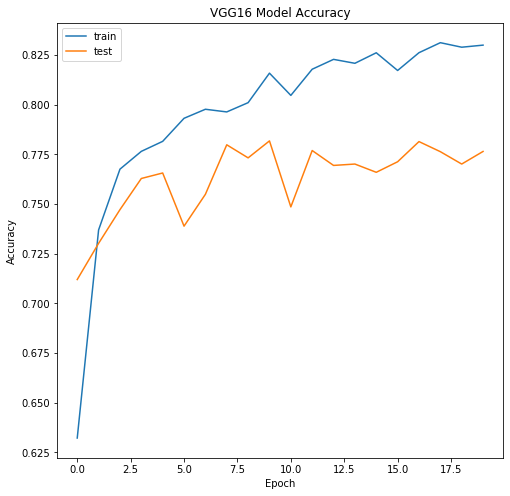

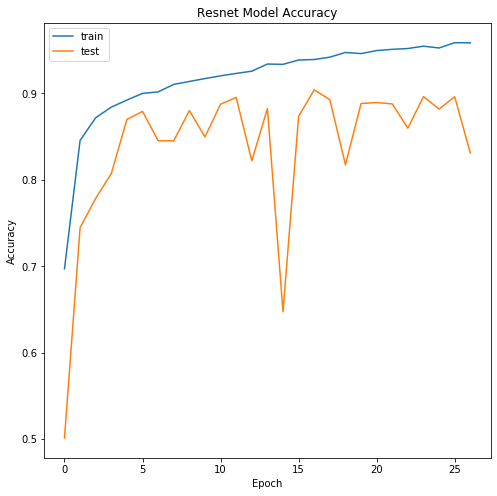

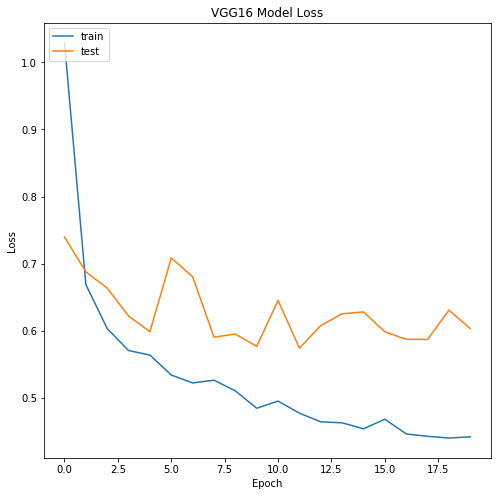

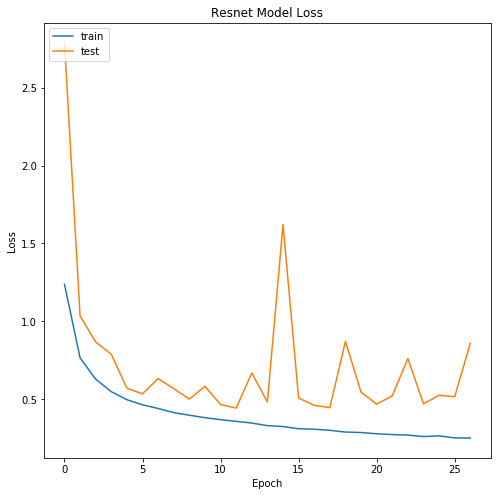

Evaluate Model 121.15935969352722 seconds


In [7]:
watch_restart()

# ===== 5. Evaluate Models
best_model_vgg16 = get_model_vgg16(IMAGE_INPUT_SHAPE, NUM_CLASSES)
best_model_vgg16.load_weights(MODEL_NAME_VGG16)
best_model_vgg16.compile(loss='categorical_crossentropy',
                         optimizer='adam',
                         metrics=['accuracy'])

best_model_resnet = get_model_resnet(input_shape=IMAGE_INPUT_SHAPE, depth=NUM_DEPTH, num_classes=NUM_CLASSES)
best_model_resnet.load_weights(MODEL_NAME_RESNET)
best_model_resnet.compile(loss='categorical_crossentropy',
                          optimizer=Adam(lr=lr_schedule(NUM_EPOCHS)),
                          metrics=['accuracy'])

def print_score(title, model, X_test, y_test, label_class):
    scores = model.evaluate(X_test, y_test, verbose=1)
    print("{0} {1} {2}".format(title, model.metrics_names[1], scores[1]*100))
    y_pred = model.predict(X_test)
    print('\n', classification_report(np.where(y_test > 0)[1], 
                                      np.argmax(y_pred, axis=1), 
                                      target_names=list(label_class.keys())), sep='')

def plot_accuracy(title, history):
    plt.figure(figsize=(8,8))
    plt.plot(history.history['acc'])     # Training Accuracy
    plt.plot(history.history['val_acc']) # Validation Accuracy
    plt.title('{0} Model Accuracy'.format(title))
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
def plot_loss(title, history):
    plt.figure(figsize=(8,8))
    plt.plot(history.history['loss'])     # Training Loss
    plt.plot(history.history['val_loss']) # Validation Loss
    plt.title('{0} Model Loss'.format(title))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
# Scores
print_score('VGG16', best_model_vgg16, X_test, y_test, LABEL_CLASS)
print_score('Resnet', best_model_resnet, X_test, y_test, LABEL_CLASS)

# Plot Accuracy 
plot_accuracy('VGG16', history_vgg16)
plot_accuracy('Resnet', history_resnet)

# Plot Model Loss
plot_loss('VGG16', history_vgg16)
plot_loss('Resnet', history_resnet)

watch_print('Evaluate Model')